# Volcano Plot

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import scanpy as sc
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
print(ad.__version__)

0.11.4


In [2]:
cell_types = [
    # "CD8-positive, alpha-beta T cell",
    "CD8-positive, alpha-beta memory T cell",
    "CD4-positive, alpha-beta T cell",
    "central memory CD4-positive, alpha-beta T cell",
    "effector memory CD4-positive, alpha-beta T cell",
    "gamma-delta T cell",
    "regulatory T cell",
    # "double negative T regulatory cell",
    # "innate lymphoid cell"
]

adata = ad.read_h5ad("../h5ad/0fce5dd5-bcec-4288-90b3-19a16b45ad16.h5ad", backed='r')

In [3]:
# Load all the excel files

excel_files_top_diff_genes = {}

for cell_type in cell_types:
    file_path = f"results/{cell_type}_top_diff_genes.xlsx"
    excel_files_top_diff_genes[cell_type] = pd.read_excel(file_path)


In [4]:
# Create a volcano plot for each cell type
# On the x-axis: is the difference between 'Correlation Young' and 'Correlation Old'
# On the y-axis: is the -log10 of the p-value

def z_score_to_p_value(z):
    """Convert a z-score to a p-value. for a two-tailed test."""
    return 2 * (1 - scipy.stats.norm.cdf(np.abs(z)))


def create_volcano_plot(df, cell_type):
    df['log_p_value_1'] = -np.log10(z_score_to_p_value(df['Z Diff Young-Middle']))
    df['log_p_value_2'] = -np.log10(z_score_to_p_value(df['Z Diff Middle-Old']))
    df['log_p_value_3'] = -np.log10(z_score_to_p_value(df['Z Diff Young-Old']))
    df['log_p_value'] = df[['log_p_value_1', 'log_p_value_2', 'log_p_value_3']].min(axis=1)
    df['Significant'] = df['log_p_value'] > -np.log10(0.01)

    df['correlation_diff_1'] = np.log2(np.abs(df['Correlation Young'] / df['Correlation Middle']))
    df['correlation_diff_2'] = np.log2(np.abs(df['Correlation Middle'] / df['Correlation Old']))
    df['correlation_diff_3'] = np.log2(np.abs(df['Correlation Young'] / df['Correlation Old']))

    df['correlation_diff_temp'] = np.where(np.abs(df['correlation_diff_1']) < np.abs(df['correlation_diff_2']),
                                        df['correlation_diff_1'], 
                                        df['correlation_diff_2'])
    df['correlation_diff'] = np.where(np.abs(df['correlation_diff_temp']) < np.abs(df['correlation_diff_3']),
                                    df['correlation_diff_temp'], 
                                    df['correlation_diff_3'])

    # Count the number of significant gene pairs
    num_significant = df['Significant'].sum()
    
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(data=df, x='correlation_diff', y='log_p_value', hue='Significant', alpha=0.7)
    
    plt.axhline(y=-np.log10(0.01), color='red', linestyle='--', label='p-value = 0.01')
    plt.axvline(x=0, color='grey', linestyle='--')

    plt.title(f'Volcano Plot for {cell_type}\nSignificant gene pairs: {num_significant}')
    plt.xlabel('Minimum Log Fold Change (Young-Middle or Middle-Old or Young-Old)', fontsize=12)
    plt.ylabel('Minimum -log10(p-value)', fontsize=12)
    
    # Modify the legend to include the count of significant pairs
    handles, labels = scatter.get_legend_handles_labels()
    # Update the 'Significant' label to include the count
    for i, label in enumerate(labels):
        if label == 'True':
            labels[i] = f'Significant (n={num_significant})'
        elif label == 'False':
            labels[i] = 'Not significant'
    
    plt.legend(handles, labels, title='Significance')
    plt.grid()

    plt.savefig(f"results/volcano_plot_{cell_type}.png")
    plt.close()

In [5]:
for cell_type, df in excel_files_top_diff_genes.items():
    # Ensure the DataFrame has the expected columns
    if 'Correlation Young' in df.columns and 'Correlation Old' in df.columns:
        create_volcano_plot(df, cell_type)
    else:
        print(f"Skipping {cell_type} due to missing columns.")

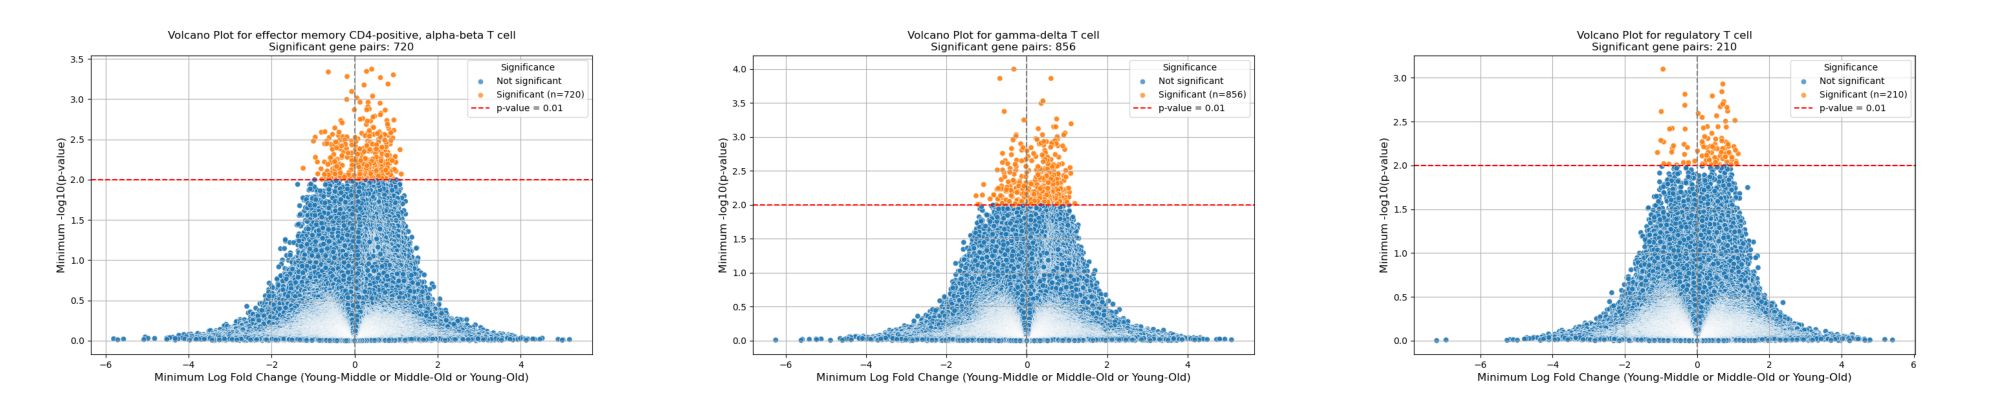

In [7]:
# add the plots together in a single image in a 2x2 grid
import matplotlib.image as mpimg
cell_types = [
    # "CD8-positive, alpha-beta memory T cell",
    # "CD4-positive, alpha-beta T cell",
    # "central memory CD4-positive, alpha-beta T cell",
    "effector memory CD4-positive, alpha-beta T cell",
    "gamma-delta T cell",
    "regulatory T cell",
]
def combine_volcano_plots(cell_types):
    fig, axs = plt.subplots(1, 3, figsize=(20, 15))
    axs = axs.flatten()
    
    for i, cell_type in enumerate(cell_types):
        img = mpimg.imread(f"results/volcano_plot_{cell_type}.png")
        axs[i].imshow(img)
        axs[i].axis('off')
    
    plt.tight_layout()
    # plt.savefig("results/combined_volcano_plots.png")
    plt.show()
    plt.close()

combine_volcano_plots(cell_types)


In [26]:
# Set a threshold for the minimum -log10(p-value) and for the minimum correlation difference
threshold_log_p_value = 2
threshold_correlation_diff = 0.7
threshold_total_correlation = 0.8

# Create a new DataFrame for each cell type where we filter the genes based on the thresholds
filtered_genes = {}

for cell_type, df in excel_files_top_diff_genes.items():
    # Ensure the DataFrame has the expected columns
    if 'log_p_value' in df.columns and 'correlation_diff' in df.columns:
        filtered_df = df[(df['log_p_value'] > threshold_log_p_value) & 
                         (np.abs(df['correlation_diff']) > threshold_correlation_diff)]
        filtered_genes[cell_type] = filtered_df[['Gene1', 'Gene2', 'log_p_value', 'correlation_diff', 
                                                  'Correlation Young', 'Correlation Middle', 'Correlation Old']]
        
        # Print the number of rows in the filtered DataFrame
        print(f"{cell_type}: {len(filtered_df) / 2} genes after filtering with thresholds "
              f"log_p_value > {threshold_log_p_value} and correlation_diff > {threshold_correlation_diff}")
        
        # Print all the rows that have a correlation of 0.8 or -0.8 in one of the columns
        for index, row in filtered_df.iterrows():
            if (row['Correlation Young'] >= threshold_total_correlation or row['Correlation Middle'] >= threshold_total_correlation or 
                row['Correlation Old'] >= threshold_total_correlation or row['Correlation Young'] <= -threshold_total_correlation or 
                row['Correlation Middle'] <= -threshold_total_correlation or row['Correlation Old'] <= -threshold_total_correlation):
                print(f"Gene1: {row['Gene1']}, Gene2: {row['Gene2']}, "
                      f"Correlation Young: {row['Correlation Young']}, "
                      f"Correlation Middle: {row['Correlation Middle']}, "
                      f"Correlation Old: {row['Correlation Old']}")
    else:
        print(f"Skipping {cell_type} due to missing columns.")

CD8-positive, alpha-beta memory T cell: 66.0 genes after filtering with thresholds log_p_value > 2 and correlation_diff > 0.7
CD4-positive, alpha-beta T cell: 19.0 genes after filtering with thresholds log_p_value > 2 and correlation_diff > 0.7
central memory CD4-positive, alpha-beta T cell: 588.0 genes after filtering with thresholds log_p_value > 2 and correlation_diff > 0.7
Gene1: ENSG00000136490, Gene2: ENSG00000108518, Correlation Young: 0.8123399063954084, Correlation Middle: 0.4094177421783629, Correlation Old: -0.1152302415057798
Gene1: ENSG00000108518, Gene2: ENSG00000136490, Correlation Young: 0.8123399063954085, Correlation Middle: 0.4094177421783629, Correlation Old: -0.1152302415057798
Gene1: ENSG00000168066, Gene2: ENSG00000136490, Correlation Young: -0.8158763458680584, Correlation Middle: -0.4981329094528582, Correlation Old: -0.08835182629168002
Gene1: ENSG00000136490, Gene2: ENSG00000168066, Correlation Young: -0.8158763458680584, Correlation Middle: -0.49813290945285

In [12]:
# Get all the distinct genes from the filtered DataFrames
distinct_genes = set()
for cell_type, df in filtered_genes.items():
    distinct_genes.update(df['Gene1'].unique())
    distinct_genes.update(df['Gene2'].unique())

# Print the number of distinct genes
print(f"Number of distinct genes across all cell types: {len(distinct_genes)}")
print(distinct_genes)

# Turn all the distinct genes into a feature names
feature_names = [(adata.var['feature_name'][gene]).split('_')[0] for gene in distinct_genes if gene in adata.var.index]

print(feature_names)

# Save the feature names to a file
with open("results/feature_names.txt", "w") as f:
    for feature in feature_names:
        f.write(f"{feature}\n")


Number of distinct genes across all cell types: 163
{'ENSG00000110321', 'ENSG00000131236', 'ENSG00000213741', 'ENSG00000273149', 'ENSG00000054654', 'ENSG00000172757', 'ENSG00000152795', 'ENSG00000108669', 'ENSG00000144746', 'ENSG00000111229', 'ENSG00000142546', 'ENSG00000113732', 'ENSG00000128340', 'ENSG00000034510', 'ENSG00000117602', 'ENSG00000120690', 'ENSG00000043462', 'ENSG00000187838', 'ENSG00000143947', 'ENSG00000115268', 'ENSG00000114391', 'ENSG00000081059', 'ENSG00000105372', 'ENSG00000146278', 'ENSG00000115085', 'ENSG00000112306', 'ENSG00000147168', 'ENSG00000122566', 'ENSG00000063046', 'ENSG00000115053', 'ENSG00000144713', 'ENSG00000197747', 'ENSG00000104904', 'ENSG00000140264', 'ENSG00000092820', 'ENSG00000138326', 'ENSG00000075624', 'ENSG00000136490', 'ENSG00000213658', 'ENSG00000051523', 'ENSG00000211772', 'ENSG00000087074', 'ENSG00000187514', 'ENSG00000205542', 'ENSG00000174886', 'ENSG00000211821', 'ENSG00000241553', 'ENSG00000081320', 'ENSG00000104979', 'ENSG00000147604

Filtered genes for CD8-positive, alpha-beta memory T cell:
                Gene1            Gene2  log_p_value  correlation_diff  \
524   ENSG00000076928  ENSG00000043462     2.340438         -1.035418   
525   ENSG00000043462  ENSG00000076928     2.340438         -1.035418   
536   ENSG00000213654  ENSG00000118181     2.097785         -1.074177   
537   ENSG00000118181  ENSG00000213654     2.097785         -1.074177   
758   ENSG00000137076  ENSG00000122566     2.318265         -1.206348   
759   ENSG00000122566  ENSG00000137076     2.318265         -1.206348   
842   ENSG00000198888  ENSG00000162511     2.142431          1.095880   
843   ENSG00000162511  ENSG00000198888     2.142431          1.095880   
852   ENSG00000124614  ENSG00000113732     2.299096          1.015528   
853   ENSG00000113732  ENSG00000124614     2.299096          1.015528   
942   ENSG00000026025  ENSG00000115085     2.304393         -1.127521   
943   ENSG00000115085  ENSG00000026025     2.304393         -1.12

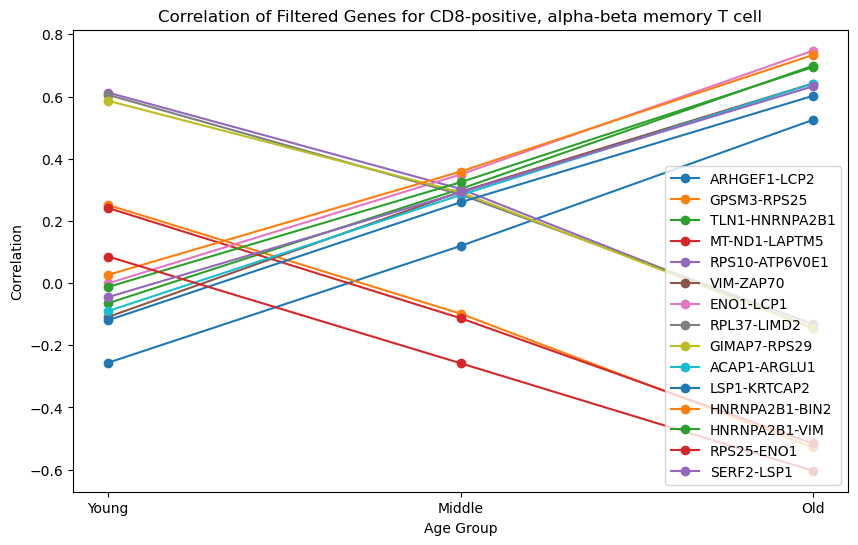

Filtered genes for CD4-positive, alpha-beta T cell:
               Gene1            Gene2  log_p_value  correlation_diff  \
14   ENSG00000125691  ENSG00000124614     2.584559         -1.016929   
15   ENSG00000124614  ENSG00000125691     2.584559         -1.016929   
52   ENSG00000147604  ENSG00000124614     2.906430         -1.047208   
53   ENSG00000124614  ENSG00000147604     2.906430         -1.047208   
150  ENSG00000147604  ENSG00000241343     2.584553         -1.015209   
151  ENSG00000241343  ENSG00000147604     2.584553         -1.015209   
172  ENSG00000197111  ENSG00000102317     2.055717         -1.083705   
173  ENSG00000102317  ENSG00000197111     2.055717         -1.083705   

     Correlation Young  Correlation Middle  Correlation Old  
14           -0.130481            0.264042         0.732434  
15           -0.130481            0.264042         0.732434  
52           -0.095483            0.341715         0.706163  
53           -0.095483            0.341715         

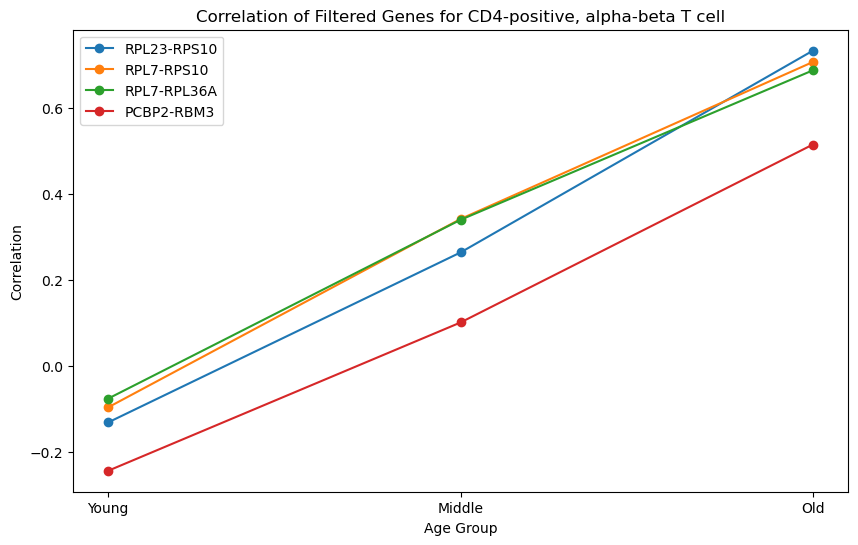

Filtered genes for central memory CD4-positive, alpha-beta T cell:
                 Gene1            Gene2  log_p_value  correlation_diff  \
78     ENSG00000103479  ENSG00000167286     3.348687          1.056711   
79     ENSG00000167286  ENSG00000103479     3.348687          1.056711   
210    ENSG00000104904  ENSG00000115053     2.601936         -1.017630   
211    ENSG00000115053  ENSG00000104904     2.601936         -1.017630   
214    ENSG00000115053  ENSG00000172531     2.009102         -1.099824   
...                ...              ...          ...               ...   
15323  ENSG00000196405  ENSG00000167526     2.047117         -1.009219   
16262  ENSG00000167526  ENSG00000115091     2.018406         -1.084245   
16263  ENSG00000115091  ENSG00000167526     2.018406         -1.084245   
16280  ENSG00000122566  ENSG00000163399     2.045805         -1.064231   
16281  ENSG00000163399  ENSG00000122566     2.045805         -1.064231   

       Correlation Young  Correlation Middle

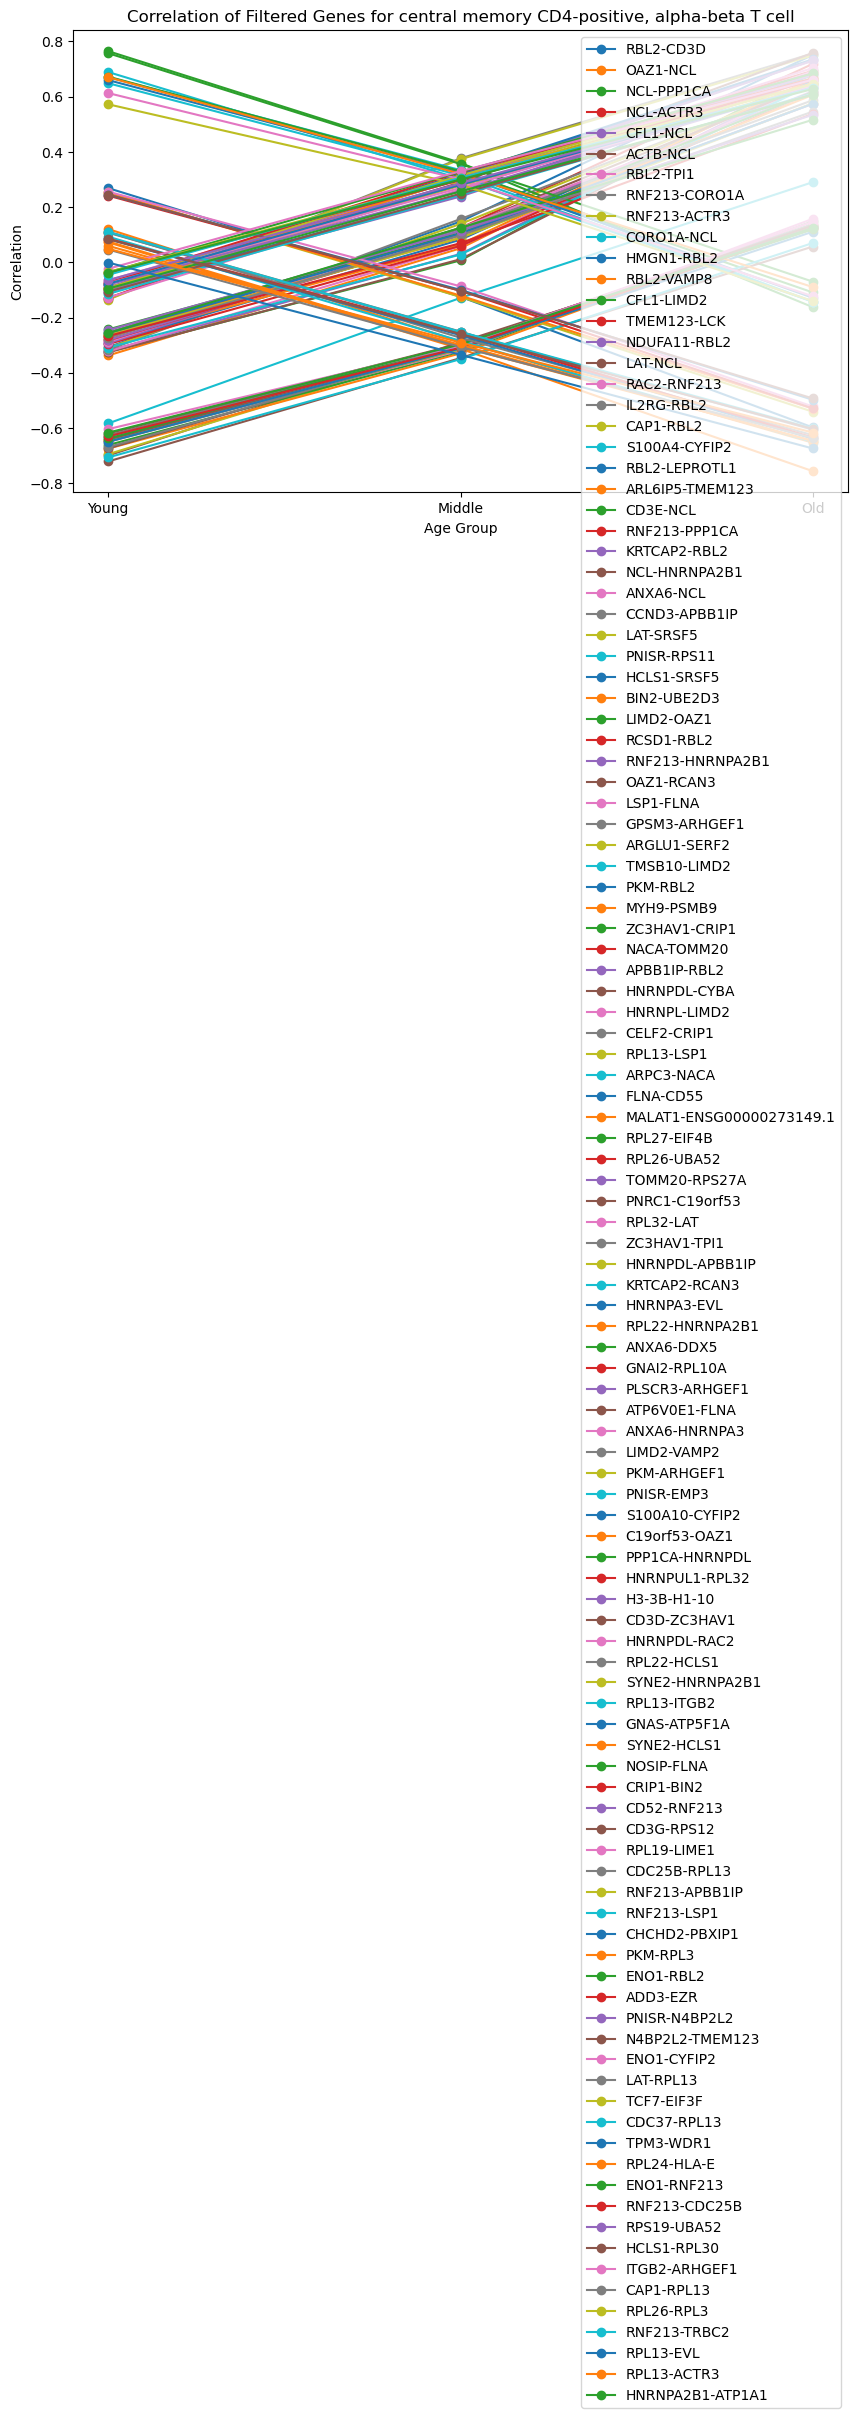

Filtered genes for effector memory CD4-positive, alpha-beta T cell:
                Gene1            Gene2  log_p_value  correlation_diff  \
710   ENSG00000187514  ENSG00000087074     2.373345          1.093622   
711   ENSG00000087074  ENSG00000187514     2.373345          1.093622   
1744  ENSG00000146278  ENSG00000198695     2.070458          1.122825   
1745  ENSG00000198695  ENSG00000146278     2.070458          1.122825   
2950  ENSG00000196531  ENSG00000205542     2.142829         -1.239554   
2951  ENSG00000205542  ENSG00000196531     2.142829         -1.239554   

      Correlation Young  Correlation Middle  Correlation Old  
710            0.696077            0.326170        -0.124432  
711            0.696077            0.326170        -0.124432  
1744           0.632502            0.290441        -0.126795  
1745           0.632502            0.290441        -0.126795  
2950           0.105650           -0.249466        -0.609092  
2951           0.105650           -0.24946

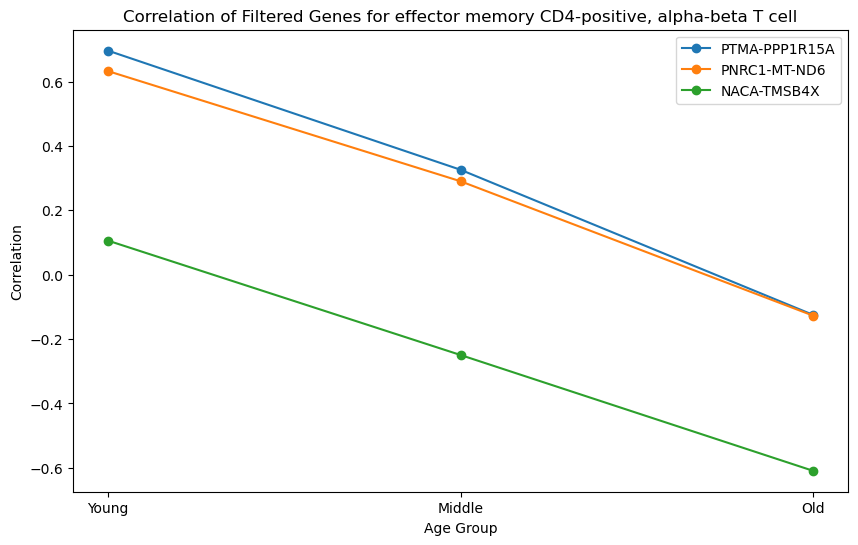

Filtered genes for gamma-delta T cell:
                Gene1            Gene2  log_p_value  correlation_diff  \
40    ENSG00000145592  ENSG00000211695     3.192129          1.103849   
41    ENSG00000211695  ENSG00000145592     3.192129          1.103849   
376   ENSG00000196262  ENSG00000137076     2.007340         -1.172237   
377   ENSG00000137076  ENSG00000196262     2.007340         -1.172237   
412   ENSG00000182899  ENSG00000160310     2.547677          1.078413   
413   ENSG00000160310  ENSG00000182899     2.547677          1.078413   
418   ENSG00000081320  ENSG00000108669     2.463261          1.094794   
419   ENSG00000108669  ENSG00000081320     2.463261          1.094794   
492   ENSG00000147168  ENSG00000124942     2.143795         -1.104057   
493   ENSG00000124942  ENSG00000147168     2.143795         -1.104057   
716   ENSG00000072786  ENSG00000211821     2.019405          1.194164   
717   ENSG00000211821  ENSG00000072786     2.019405          1.194164   
1014  ENSG00

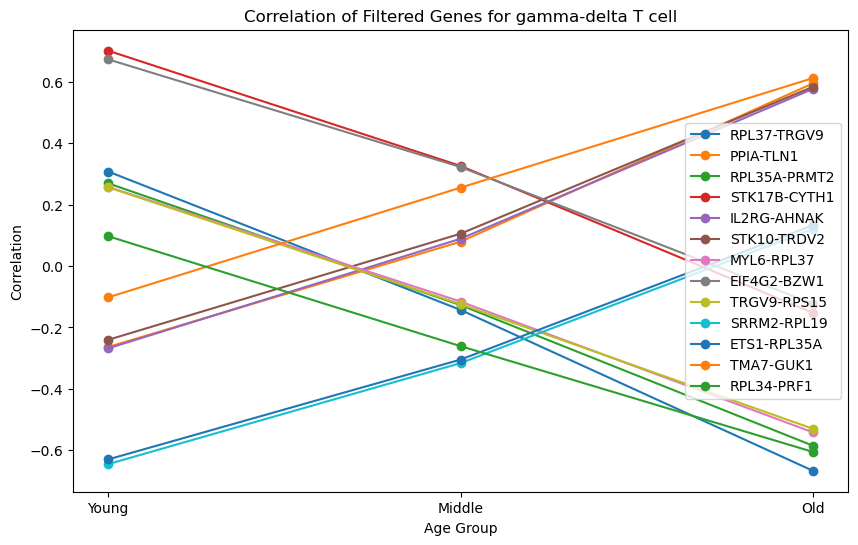

Filtered genes for regulatory T cell:
               Gene1            Gene2  log_p_value  correlation_diff  \
82   ENSG00000177954  ENSG00000179144     2.512308          1.048362   
83   ENSG00000179144  ENSG00000177954     2.512308          1.048362   
166  ENSG00000145592  ENSG00000179144     2.133092          1.138591   
167  ENSG00000179144  ENSG00000145592     2.133092          1.138591   
238  ENSG00000155657  ENSG00000117523     2.214691          1.019797   
239  ENSG00000117523  ENSG00000155657     2.214691          1.019797   
318  ENSG00000026508  ENSG00000120616     2.173824          1.062703   
319  ENSG00000120616  ENSG00000026508     2.173824          1.062703   
470  ENSG00000163682  ENSG00000140264     2.146877         -1.096359   
471  ENSG00000140264  ENSG00000163682     2.146877         -1.096359   
588  ENSG00000179144  ENSG00000138326     2.046581          1.076721   
589  ENSG00000138326  ENSG00000179144     2.046581          1.076721   
622  ENSG00000108298  ENSG

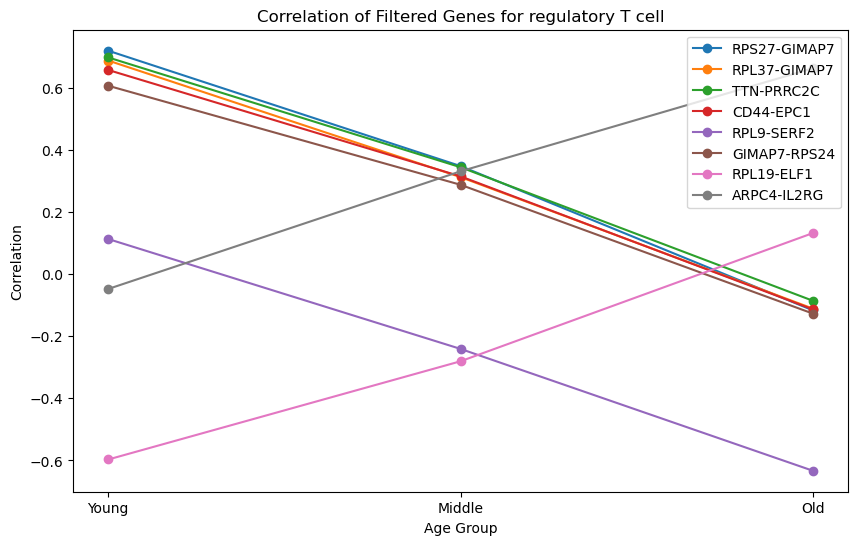

In [13]:
# Print the filtered genes for each cell type
for cell_type, df in filtered_genes.items():
    print(f"Filtered genes for {cell_type}:")
    print(df)
    print("\n")

    # Plot the young, middle and old correlations for the filtered genes for every even row
    plt.figure(figsize=(10, 6))
    for i in range(0, len(df), 2):
        row = df.iloc[i]
        gene_1 = row['Gene1']
        gene_2 = row['Gene2']
        feature_1 = (adata.var['feature_name'][gene_1]).split('_')[0]
        feature_2 = (adata.var['feature_name'][gene_2]).split('_')[0]
        label_genes = feature_1 + '-' + feature_2
        plt.plot(['Young', 'Middle', 'Old'], 
                 [row['Correlation Young'], row['Correlation Middle'], row['Correlation Old']], 
                 marker='o', label=label_genes)
    plt.title(f'Correlation of Filtered Genes for {cell_type}')
    plt.xlabel('Age Group')
    plt.ylabel('Correlation')
    plt.legend()
    plt.show()